In [1]:
from trenchripper.utils import kymo_handle,pandas_hdf5_handler,writedir
from trenchripper.segment import phase_segmentation, phase_segmentation_cluster
from trenchripper.cluster import dask_controller
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import os
import h5py
import resource
%load_ext line_profiler
import random

In [2]:
import dask

In [3]:
headpath = "/n/scratch2/bj66/vibrio_30_balanced2"

In [4]:
segmenter = phase_segmentation_cluster(headpath,
            seg_channel="Phase",init_niblack_k=-0.45,
            maxima_niblack_k=-0.8, init_smooth_sigma=4,
            maxima_smooth_sigma=3, init_niblack_window_size=13,
            maxima_niblack_window_size=13, min_cell_size=100,
            deviation_from_median=0.3, max_perc_contrast=97,
            wrap_pad=0)

In [ ]:
kymodf = segmenter.meta_handle.read_df("kymograph",read_metadata=True)
metadata = kymodf.metadata

In [ ]:
        kymodf = kymodf.reset_index()
        kymodf = kymodf.set_index(["File Index", "File Trench Index", "timepoints"])

In [ ]:
kymodf

In [ ]:
kymodf = segmenter.meta_handle.read_df("kymograph",read_metadata=True)
file_indices = kymodf["File Index"].unique().tolist()
random.shuffle(file_indices)
file_idx = 0

In [ ]:
data = segmenter.load_trench_array_list(segmenter.kymographpath + "/kymograph_", file_idx, segmenter.seg_channel, True)

In [ ]:
data.shape

In [ ]:
# trench = data[0,:]
trench = data[np.random.randint(data.shape[0]),:]
timepoint = np.random.randint(trench.shape[0])
img = trench[timepoint,:,:]
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.imshow(img)

In [ ]:
conn_comp, trench_masks, img_mask, maxima = segmenter.segment(img, return_all=True, show_plots=True)

In [ ]:
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(8,10))

ax1.imshow(img,cmap='gray')
ax2.imshow(conn_comp, cmap='inferno_r')
ax3.imshow(img_mask,cmap='gray')
ax4.imshow(maxima, cmap='gray')
if trench_masks is not None:
    ax5.imshow(trench_masks, cmap='gray')

In [ ]:
dc = dask_controller(walltime='6:00:00',local=False,n_workers=50,memory='7.5GB',death_timeout=120.,working_directory=headpath+"/dask")
dc.startdask()
dc.daskcluster.start_workers()

In [ ]:
dc.displaydashboard()

In [ ]:
segmenter.dask_segment(dc)

In [ ]:
dc.shutdown()

# Check results

In [ ]:
kymodf = segmenter.meta_handle.read_df("kymograph",read_metadata=True)
file_indices = kymodf["File Index"].unique().tolist()
random.shuffle(file_indices)
file_idx = file_indices[0]
with h5py.File(segmenter.phasesegmentationpath + "/segmentation_" + str(file_idx) + ".hdf5","r") as input_file:
    data = input_file["data"][:]


In [ ]:
trench_idx = np.random.randint(data.shape[0])
time_idx = np.random.randint(data.shape[1])
img = data[trench_idx, time_idx,:,:]
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.imshow(img)
print("File %d, Trench %d, Time %d" %(file_idx, trench_idx, time_idx))

# Get loading fractions

In [ ]:
dc = dask_controller(walltime='4:00:00',local=False,n_workers=40,memory='4GB',death_timeout=120.,working_directory=headpath+"/dask")
dc.startdask()
dc.daskcluster.start_workers()

In [ ]:
dc.displaydashboard()

In [ ]:
segmenter.dask_characterize_trench_loading(dc)

In [ ]:
segmenter.dask_postprocess_trench_loading(dc)

In [ ]:
trench_loadings = np.concatenate(dc.daskclient.gather(dc.futures["Trench Loading"]), axis=0)


In [ ]:
dc.shutdown()

In [ ]:
fig1, ax1= plt.subplots(figsize=(10,10))

ax1.hist(trench_loadings, bins=40)
ax1.set_ylabel("Count")
ax1.set_xlabel("Loading fraction")

# Test get cell properties

In [ ]:
kymodf = segmenter.meta_handle.read_df("kymograph",read_metadata=True)

In [ ]:
metadata = kymodf.metadata

In [ ]:
kymodf = kymodf.reset_index()
kymodf = kymodf.set_index(["File Index", "File Trench Index", "timepoints"])

In [ ]:
file_idx = np.random.randint(500)

In [ ]:
times = kymodf.loc[file_idx, "time (s)"]
global_trench_indices = kymodf.loc[file_idx, "trenchid"]
trench_loadings = kymodf.loc[file_idx, "Trench Loading"]

In [ ]:
writedir(segmenter.phasedatapath,overwrite=True)

In [ ]:
columns = ['area', 'centroid', 'label', 'major_axis_length', 'minor_axis_length']

In [ ]:
%lprun -f segmenter.extract_cell_data segmenter.extract_cell_data(file_idx, times, global_trench_indices, trench_loadings, columns, metadata)

In [ ]:
from pandas import HDFStore
store = HDFStore(os.path.join(segmenter.phasedatapath, "data_%d.h5" % file_idx))

In [ ]:
testdf = store.get("metrics")

In [ ]:
testdf.shape

# Get cell properties

In [ ]:
dc = dask_controller(walltime='4:00:00',local=False,n_workers=50,memory='2GB',death_timeout=120.,working_directory=headpath+"/dask")
dc.startdask()
dc.daskcluster.start_workers()

In [ ]:
dc.displaydashboard()

In [ ]:
columns = ['area', 'centroid', 'label', 'major_axis_length', 'minor_axis_length']
segmenter.dask_extract_cell_data(dc, columns)

In [ ]:
dc.shutdown()

In [ ]:
lost_count = 0
for key, value in dc.futures.items():
    if value.status == "lost":
        print(key)

# Check proprety extraction results

In [ ]:
from pandas import HDFStore
import pandas as pd
import random


In [ ]:
kymodf = segmenter.meta_handle.read_df("kymograph",read_metadata=True)
file_indices = kymodf["File Index"].unique().tolist()
random.shuffle(file_indices)
file_idx = file_indices[0]
p = os.path.join(segmenter.phasedatapath, "data_%d.h5" % file_idx)
test_df = pd.read_hdf(p)
len(test_df.index.unique("time_s"))

In [ ]:
trenches = list(test_df.index.unique("file_trench_index"))
random.shuffle(trenches)
trench_idx = trenches[0]
time_idx = 0

In [ ]:
# Show segmentation mask
with h5py.File(segmenter.phasesegmentationpath + "/segmentation_" + str(file_idx) + ".hdf5","r") as input_file:
    data = input_file["data"][:]

In [ ]:
times = test_df.loc[trench_idx].index.unique("time_s")

In [ ]:
test_df_refactored = test_df.reset_index().set_index(["file_trench_index", "trench_cell_index"])

In [ ]:
fig1, axes = plt.subplots(1, 15, figsize=(20, 10))
for i, ax in enumerate(axes):
    ax.imshow(data[trench_idx, time_idx+i,:,:], cmap="inferno_r")
    ax.scatter(test_df.loc[trench_idx, times[time_idx+i]]["centx"], test_df.loc[trench_idx, times[time_idx+i]]["centy"])

# Try lineage single-cell growth rates

# Get all growth properties

In [5]:
from trenchripper.tracking import mother_tracker
import pandas as pd
import os
from pandas import HDFStore

In [6]:
headpath = "/n/scratch2/bj66/vibrio_30_balanced2"

In [7]:
tracker = mother_tracker(headpath)

/home/bj66/TrenchRipper/trenchripper/utils.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [ ]:
tracker.save_all_growth_props()

In [ ]:
dts = pd.read_hdf(os.path.join(tracker.phasesegmentationpath, "growth_properties.h5"), "doubling_times")

In [ ]:
growth_rates.index.unique("trenchid")

# Inspect trenches

In [8]:
headpath = "/n/scratch2/bj66/vibrio_30_balanced2"
segmenter = phase_segmentation_cluster(headpath,
            seg_channel="Phase",init_niblack_k=-0.45,
            maxima_niblack_k=-0.8, init_smooth_sigma=4,
            maxima_smooth_sigma=3, init_niblack_window_size=13,
            maxima_niblack_window_size=13, min_cell_size=100,
            deviation_from_median=0.3, max_perc_contrast=97,
            wrap_pad=0)

In [9]:
from pandas import HDFStore
import pandas as pd
import random
import scipy.signal as signal
from trenchripper.DetectPeaks import detect_peaks
kymodf = segmenter.meta_handle.read_df("kymograph",read_metadata=True)
file_indices = kymodf["File Index"].unique().tolist()
random.shuffle(file_indices)


In [10]:
trenchid = 1428
file_idx = kymodf.loc[trenchid]["File Index"].unique()[0]

In [11]:
p = os.path.join(segmenter.phasedatapath, "data_%d.h5" % file_idx)
test_df = pd.read_hdf(p)
test_df  = test_df[test_df["trenchid"] == trenchid]

In [12]:
loadings = np.array(kymodf.loc[trenchid]["Trench Loading"])
outside = ~ (loadings > 0.35)*(loadings<0.75)

In [13]:
trench_idx = test_df.index.unique("file_trench_index")[0]
times = test_df.loc[trench_idx].index.unique("time_s")

In [14]:
# Show segmentation mask
with h5py.File(segmenter.phasesegmentationpath + "/segmentation_" + str(file_idx) + ".hdf5","r") as input_file:
    data = input_file["data"][trench_idx]

In [15]:
trench_df = test_df.loc[trench_idx]
xs = []
ys = []
for time_s in trench_df.index.unique("time_s"):
    xs.append(time_s/60)
    ys.append(trench_df.loc[time_s].iloc[0]["major_axis_length"])

In [16]:
interpolated_ys = tracker.repair_trench_loadings(np.array(ys)[:, None], outside)

In [17]:
ys[429]

2.6052254730836073

In [20]:
interpolated_ys.shape

(1362, 1)

In [21]:
ind = detect_peaks(signal.wiener(interpolated_ys.ravel()), relative_threshold=1.5)
print(ind)

[   7   31   59   88  113  133  156  184  203  225  256  278  305  336
  358  418  431  453  479  502  531  558  585  610  640  664  685  710
  734  756  784  808  840  863  902  944  958  980 1006 1031 1046 1080
 1101 1132 1159 1187 1189 1213 1242 1267 1296 1316 1340 1357]


(0, 500)

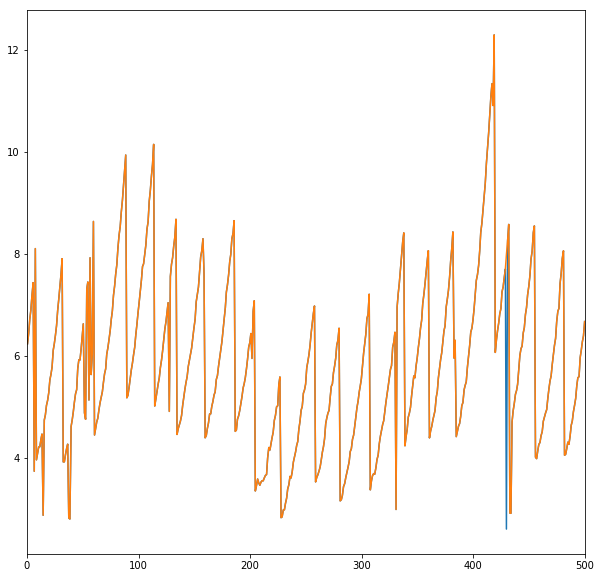

In [22]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.plot(xs[:500], ys[:500])
ax1.plot(xs[:500], interpolated_ys[:500])
plt.xlim(0, 500)

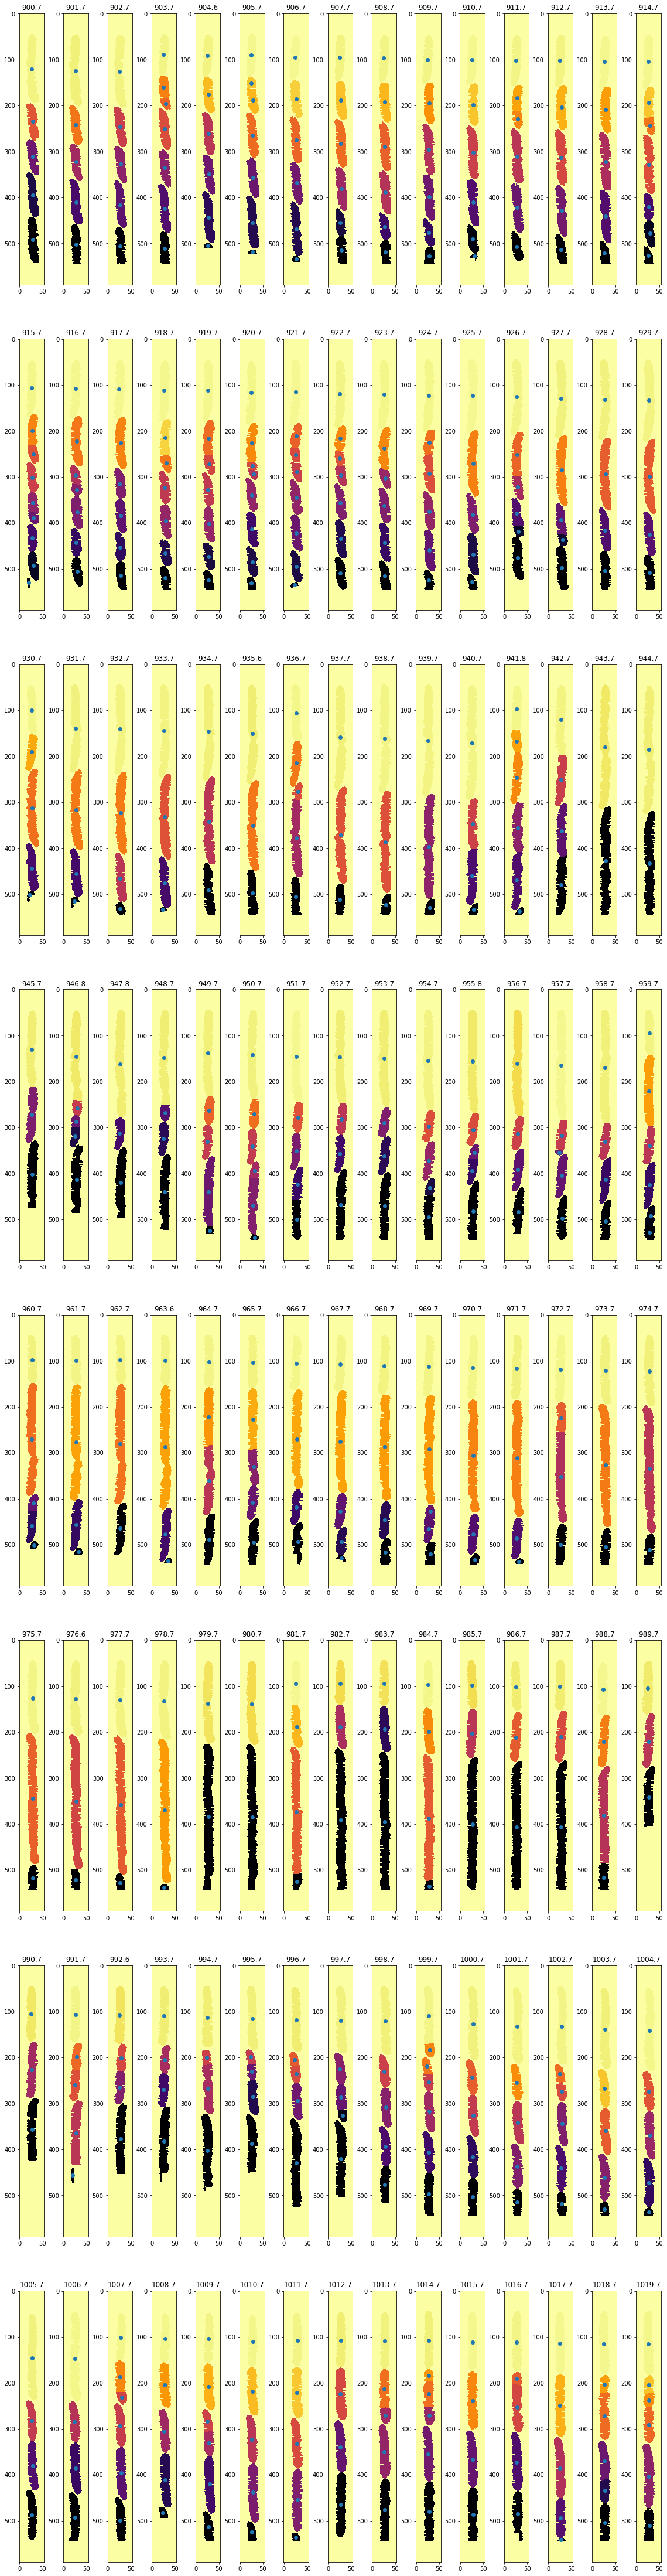

In [24]:
time_idx = 900
n_rows = 8
fig1, axes = plt.subplots(1*n_rows, 15, figsize=(20, 10*n_rows))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(data[time_idx+i,:,:], cmap="inferno_r")
    ax.set_title("%.1f" % (times[time_idx+i]/60))
    ax.scatter(test_df.loc[trench_idx, times[time_idx+i]]["centx"], test_df.loc[trench_idx, times[time_idx+i]]["centy"])